In [677]:
# Imports
# # Data types and classes
from pandas import DataFrame, Series, Index
from numpy import ndarray, floating, uint16
# #
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
# #
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
# # Decision Tree for comparison
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
# # If any figures change, set to true
gen_new_plot: bool = False

<!-- ### Drop attributes or records to fine-tune the KNN model

A KNN model on the full dataset yields a high misclassification rate for certain cars such as the "Tourneo Connect" and the "Fusion" models. The cars with higher misclassification rates will isolated to a separate KNN model to study the behavior related to the high misclassification rates.

The primary dataset to be examined is stored to `df` and is exported to the "clean1_Ford.csv" file. 

The car models with high misclassification rates are stored in `df2` and exported to the "clean2_Ford.csv" file. -->

---

# Section 2 : Scaling the Data

Scale the dataset. Additionaly, multiply the "mpg scaled" attribute by a weight of `mpg_weight` to adjust the impact for groupings of this attribute.

In [678]:
mpg_weight: float = 7.0

# use mpg_col_name to rename the columns after adjusting the "mpg scaled" feature
mpg_col_name: str = "mpg scaled * " + str(mpg_weight)
print("mpg_col_name: \'" + mpg_col_name + "\'")

mpg_col_name: 'mpg scaled * 7.0'


In [679]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [680]:
scaler: MinMaxScaler = MinMaxScaler()
scaler.fit(X)
X_scaled_mpg_x_7_0 = scaler.transform(X)
columns: Index = X.columns + " scaled"
X_scaled_mpg_x_7_0: DataFrame = pd.DataFrame(X_scaled_mpg_x_7_0, columns=columns)

In [681]:
# adjust the 'mpg scaled' feature
mpg_scaled: DataFrame = X_scaled_mpg_x_7_0["mpg scaled"].to_frame(name=mpg_col_name)*mpg_weight
X_scaled_mpg_x_7_0: DataFrame = pd.concat([X_scaled_mpg_x_7_0.drop("mpg scaled", axis=1), mpg_scaled], axis=1)
display(X_scaled_mpg_x_7_0.head())

,year scaled,price scaled,mileage scaled,engineSize scaled,Automatic scaled,Manual scaled,Semi-Auto scaled,Diesel scaled,Electric scaled,Hybrid scaled,Petrol scaled,mpg scaled * 7.0
0,0.875000,0.211101,0.089747,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.427072
1,0.916667,0.247798,0.051125,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.427072
2,0.875000,0.229450,0.070113,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.427072
3,0.958333,0.312018,0.058877,0.3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.754144
4,0.958333,0.293670,0.008337,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.079006


In [682]:
# X_scaled_mpg_x_7_0.to_csv("X_scaled_mpg_x_7.0.csv")

---

# Section 3: Designing the KNN Model

Read the scaled data from files. Store the features and targets to variables. These variables will be used for train-test splitting.

In [683]:
# read the target attribute
y = y.to_numpy().ravel()

### study interactions

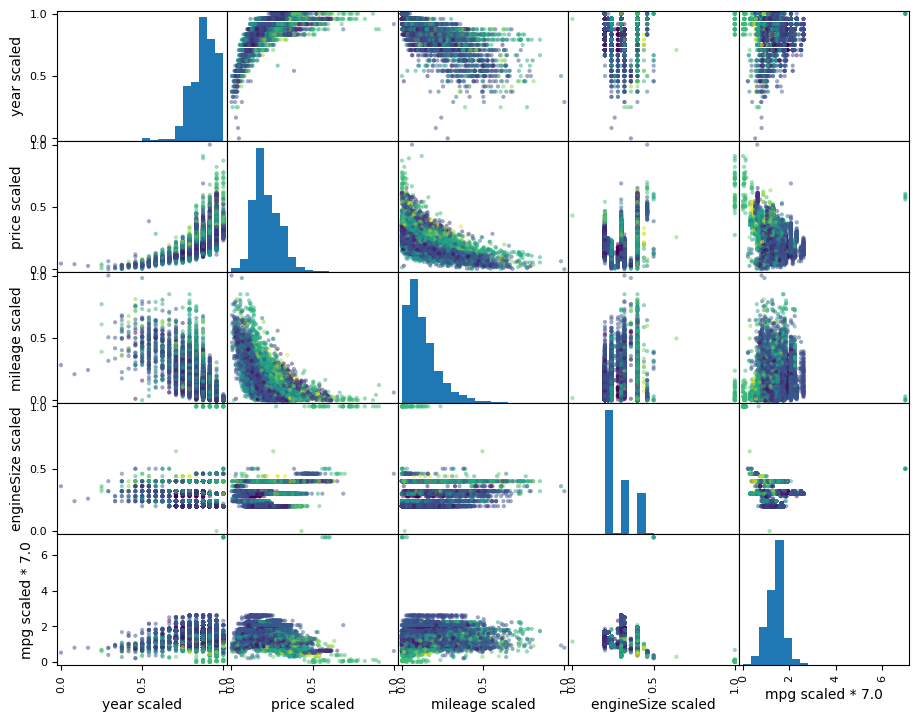

In [684]:
if (gen_new_plot):
    # labels for pairwise plots
    from sklearn.preprocessing._label import LabelEncoder

    pd.plotting.scatter_matrix(
        X_scaled_mpg_x_7_0[X_scaled_mpg_x_7_0.columns[[0,1,2,3,11]]],
        c=LabelEncoder().fit(y).transform(y),
        diagonal='hist',
        hist_kwds={'bins':20},
        figsize=(11, 8.5),
    )
    plt.show()
else:
    display(Image(".CompiledKNN_mpg_x_7.0/PairPlot.png"))

Divide data into training and test sets

In [685]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled_mpg_x_7_0, y, random_state=0)

In [686]:
display(X_train_scaled.shape, y_train.shape)
display(X_test_scaled.shape, y_test.shape)

(13434, 12)

(13434,)

(4479, 12)

(4479,)

--- 

# Section 4: Decision Tree Comparision

Create a decision tree and a KNN from the dataset and compare accuracies of each model

In [687]:
tree: DecisionTreeClassifier = DecisionTreeClassifier(
    random_state=0
)
knn: KNeighborsClassifier = KNeighborsClassifier()


# import the scaled data and split into training and test sets
X_scaled = pd.read_csv("X_scaled.csv")
y = pd.read_csv("y.csv")

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, random_state=0)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)

# hacky way to clear the output
display() 

In [688]:
print("Accuracies on the test set")
print("tree accuracy: " + str(tree.score(X_test_scaled, y_test)))
print("knn accuracy: " + str(knn.score(X_test_scaled, y_test)))

Accuracies on the test set
tree accuracy: 0.9229738780977896
knn accuracy: 0.8374637195802634


Create a decision tree and a KNN from the secondary dataset and compare accuracies of each model

---

# Section 5: Cross Validation

Evaluate the accuracy of a 10-fold cross validation for the KNN model.

In [689]:
features: DataFrame = X_scaled_mpg_x_7_0

In [690]:
target: DataFrame = pd.DataFrame(y, columns=["model"])

In [691]:
models:list = target.model.unique().tolist()

In [692]:
indexes: ndarray[uint16] = np.empty(shape=0, dtype=np.uint16)

display(target.shape[0])

for model in models:
    mask:Series = (target.model == model)
    if (target[mask].shape[0] <= 50):
        index: Index = target[mask].index[:]
        print(model, "- remove", index.shape[0], "record(s)")
        indexes = np.append(indexes, index)

target: DataFrame = target.drop(index=indexes, axis=0)
features: DataFrame = features.drop(index=indexes, axis=0)

display(target.shape[0])

17913

 Tourneo Connect - remove 33 record(s)
 Fusion - remove 16 record(s)
 Ranger - remove 1 record(s)
 Streetka - remove 2 record(s)
 Escort - remove 1 record(s)
 Transit Tourneo - remove 1 record(s)


17859

In [693]:
models:list = target.model.unique().tolist()

In [694]:
print(models)

[' Fiesta', ' Focus', ' Puma', ' Kuga', ' EcoSport', ' C-MAX', ' Mondeo', ' Ka+', ' Tourneo Custom', ' S-MAX', ' B-MAX', ' Edge', ' Grand C-MAX', ' KA', ' Galaxy', ' Mustang', ' Grand Tourneo Connect']


In [695]:
target:ndarray = target.to_numpy().ravel()

In [696]:
knn: KNeighborsClassifier = KNeighborsClassifier()
cv:ndarray = cross_val_score(knn, features, target, cv=10)


In [697]:
cv.mean()

0.9184125833984209

In [698]:
tree: DecisionTreeClassifier = DecisionTreeClassifier(
    random_state=0
)

cv_tree:ndarray = cross_val_score(tree, features, target, cv=10)
cv_tree.mean()

0.9235658608348155

---


# Accuracy Assessment on individual targets

In [699]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    features, target,
    random_state=0
)

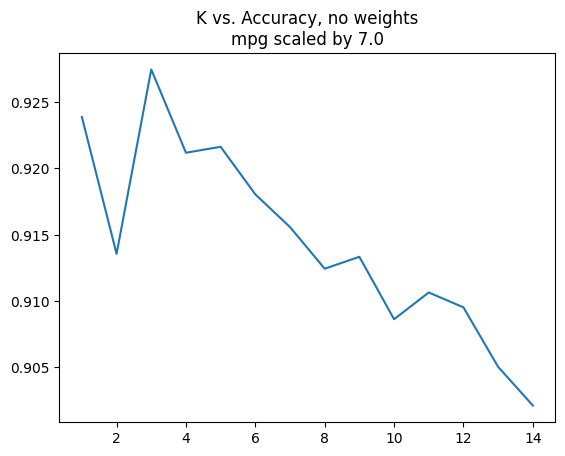

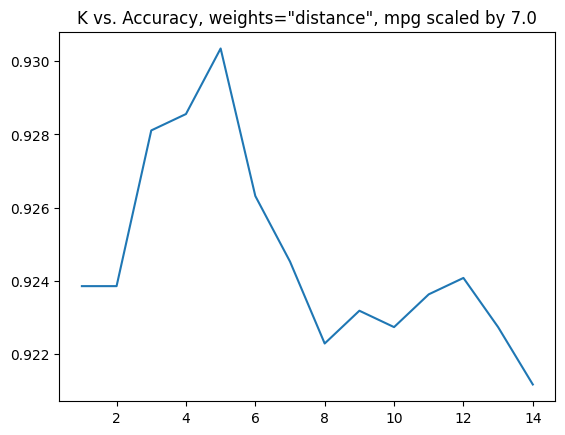

In [700]:
if (gen_new_plot):
    # KNN without distance weighting
    arr = np.array([])
    y_test = y_test.squeeze()
    for n in range(1,15):
        knn = KNeighborsClassifier(n_neighbors=n, weights="uniform")
        knn.fit(X_train_scaled, y_train)
        y1_predict = knn.predict(X_test_scaled)
        m = np.mean(y1_predict == y_test)
        arr = np.append(arr, np.array(m))
    plt.plot(range(1, arr.size+1), arr)
    plt.title("K vs. Accuracy, no weights\nmpg scaled by 7.0")
    plt.show()
    # KNN with distance weighting
    arr = np.array([])
    y_test = y_test.squeeze()
    for n in range(1,15):
        knn = KNeighborsClassifier(n_neighbors=n, weights="distance")
        knn.fit(X_train_scaled, y_train)
        y1_predict = knn.predict(X_test_scaled)
        m = np.mean(y1_predict == y_test)
        arr = np.append(arr, np.array(m))
    plt.plot(range(1, arr.size+1), arr)
    plt.title("K vs. Accuracy, weights=\"distance\", mpg scaled by 7.0")
    plt.show()
else:
    filename = ".CompiledKNN_mpg_x_7.0/K versus accuracy.png"
    display(Image(filename=filename))
    filename = ".CompiledKNN_mpg_x_7.0/K vs. Accuracy - weighted.png"
    display(Image(filename=filename))

In [701]:
# No weights
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
y_predict = knn.predict(X_test_scaled)
print("KNN Test accuracy: ", knn.score(X_test_scaled, y_test))
print("KNN training accuracy: ", knn.score(X_train_scaled, y_train))

# Weighted
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(X_train_scaled, y_train)
y_predict = knn.predict(X_test_scaled)
print("KNN Test accuracy: ", knn.score(X_test_scaled, y_test))
print("KNN training accuracy: ", knn.score(X_train_scaled, y_train))

KNN Test accuracy:  0.9274356103023517
KNN training accuracy:  0.9584888756159474
KNN Test accuracy:  0.9303471444568869
KNN training accuracy:  1.0


array([' Fiesta', ' C-MAX', ' KA', ' S-MAX', ' Kuga', ' Grand C-MAX',
       ' Focus', ' Puma', ' B-MAX', ' Mondeo', ' Galaxy', ' Ka+',
       ' EcoSport', ' Edge', ' Grand Tourneo Connect', ' Mustang',
       ' Tourneo Custom'], dtype=object)

(311,)

311

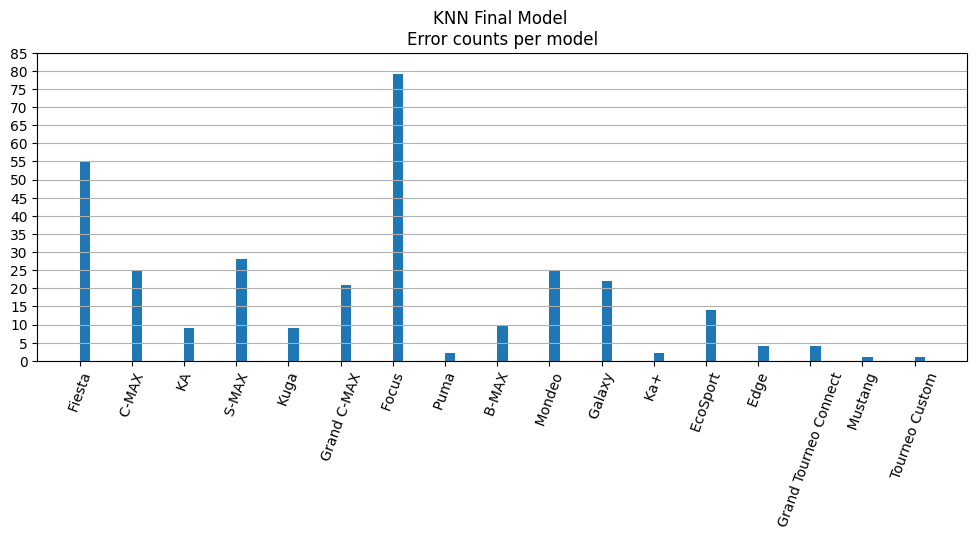

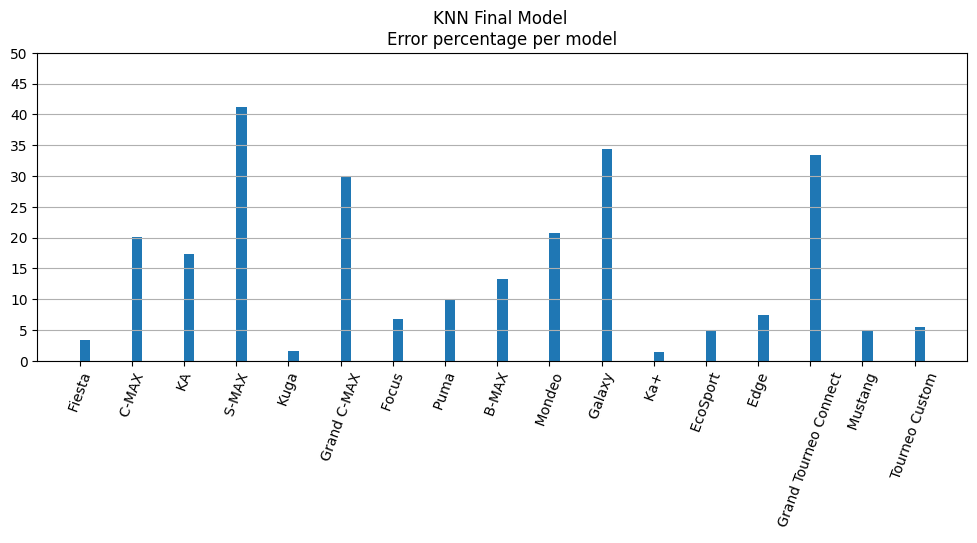

In [702]:
# misclassified_y = pd.DataFrame(y_test[y_test != y_predict], columns=["model"])

misclassified_y = y_test[y_test != y_predict]

names = pd.Series(misclassified_y).unique()
sum = 0
error_counts = np.array([])
name_counts = np.array([])
for name in names:
    errors = misclassified_y[misclassified_y == name].shape[0]
    sum += errors
    error_counts = np.append(error_counts, np.array(errors))
    name_total = y_test[y_test == name].shape[0]
    name_counts = np.append(name_counts, np.array(name_total))
display(names, misclassified_y.shape, sum)

error_percentage = 100 * error_counts / name_counts



# Plot misclassifications
plt.figure(figsize=(12, 4))
plt.bar(range(error_counts.size), height=error_counts, align='edge', width=0.2)
plt.xticks(range(error_counts.size), names, rotation=70)
plt.title("KNN Final Model \nError counts per model")
plt.xticks(range(error_counts.size), names, rotation=70)
plt.yticks(range(0, int(error_counts.max())+10, 5))
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(range(error_counts.size), height=error_percentage, align='edge', width=0.2)
plt.xticks(range(error_counts.size), names, rotation=70)
plt.title("KNN Final Model \nError percentage per model")
plt.xticks(range(error_counts.size), names, rotation=70)
plt.yticks(range(0, int(error_percentage.max())+10,5))
plt.grid(axis='y')
plt.show()

### Assess Accuracy of decision tree for comparison

In [703]:
tree = DecisionTreeClassifier(
    random_state=0
)
tree.fit(X_train_scaled, y_train)
y_predict = tree.predict(X_test_scaled)
display(tree.score(X_test_scaled, y_test))

0.9269876819708847

array([' Fiesta', ' C-MAX', ' KA', ' S-MAX', ' EcoSport', ' Kuga',
       ' Grand C-MAX', ' Tourneo Custom', ' Puma', ' Mondeo', ' Ka+',
       ' Galaxy', ' Focus', ' B-MAX', ' Edge', ' Grand Tourneo Connect'],
      dtype=object)

(326,)

326

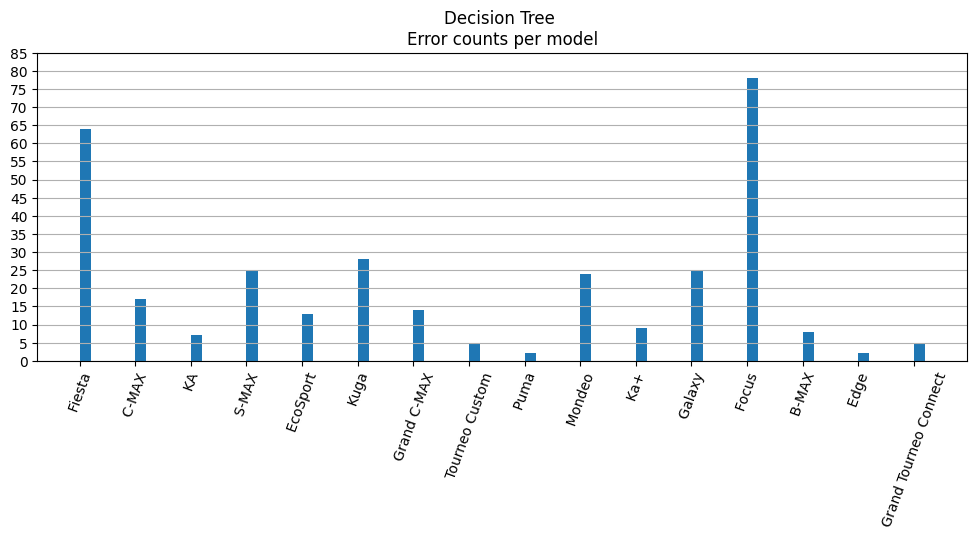

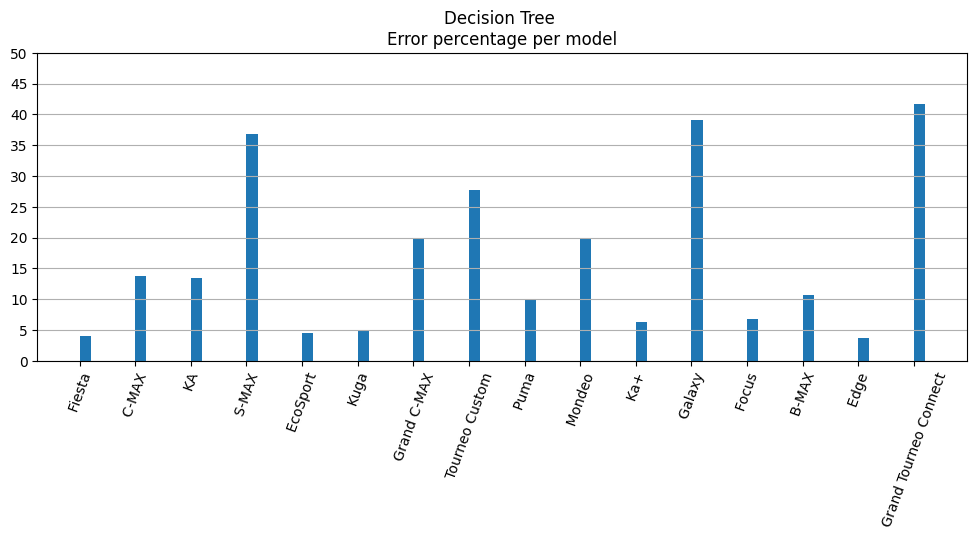

In [704]:
misclassified_y = y_test[y_test != y_predict]

names = pd.Series(misclassified_y).unique()
sum = 0
error_counts = np.array([])
name_counts = np.array([])
for name in names:
    errors = misclassified_y[misclassified_y == name].shape[0]
    sum += errors
    error_counts = np.append(error_counts, np.array(errors))
    name_total = y_test[y_test == name].shape[0]
    name_counts = np.append(name_counts, np.array(name_total))
display(names, misclassified_y.shape, sum)

error_percentage = 100 * error_counts / name_counts



# Plot misclassifications
plt.figure(figsize=(12, 4))
plt.bar(range(error_counts.size), height=error_counts, align='edge', width=0.2)
plt.xticks(range(error_counts.size), names, rotation=70)
plt.title("Decision Tree \nError counts per model")
plt.yticks(range(0, int(error_counts.max())+10, 5))
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 4))
plt.bar(range(error_counts.size), height=error_percentage, align='edge', width=0.2)
plt.xticks(range(error_counts.size), names, rotation=70)
plt.yticks(range(0, int(error_percentage.max())+10,5))
plt.grid(axis='y')
plt.title("Decision Tree \nError percentage per model")
plt.show()

In [705]:
display(tree.feature_importances_)
display(tree.feature_names_in_)

array([0.05817145, 0.12678898, 0.05619194, 0.1961206 , 0.00259822,
       0.04724242, 0.00134229, 0.00176652, 0.        , 0.00050045,
       0.02066149, 0.48861562])

array(['year scaled', 'price scaled', 'mileage scaled',
       'engineSize scaled', 'Automatic scaled', 'Manual scaled',
       'Semi-Auto scaled', 'Diesel scaled', 'Electric scaled',
       'Hybrid scaled', 'Petrol scaled', 'mpg scaled * 7.0'], dtype=object)